In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score, 
    average_precision_score
)
from sklearn.datasets import make_classification
from logreg import LogRegCCD, generate_dataset
from sklearn.preprocessing import StandardScaler

import random
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
import json
from tqdm import tqdm

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
# def evaluate_logreg_ccd(X_train, y_train, X_test, y_test, dataset_name, 
#                         num_lambdas=10, lambda_min=1e-3, lambda_max=1.0, alpha=0.2):
#     """
#     Evaluate LogRegCCD with multiple metrics and save results and plots.
    
#     Args:
#         X_train: Training data features
#         y_train: Training data labels
#         X_test: Test data features
#         y_test: Test data labels
#         dataset_name: Name of the dataset (used for saving files)
#         num_lambdas: Number of lambda values to evaluate
#         lambda_min: Minimum lambda value
#         lambda_max: Maximum lambda value
#         alpha: Elastic net mixing parameter
        
#     Returns:
#         Dictionary with results for all metrics
#     """
#     import os
#     import json
#     from datetime import datetime
#     import matplotlib.pyplot as plt
    
#     # Turn off interactive mode to prevent displaying plots
#     plt.ioff()
    
#     # Create dataset-specific directory
#     dataset_dir = f"results/real/{dataset_name}"
#     os.makedirs(dataset_dir, exist_ok=True)
    
#     # Metrics to evaluate
#     metrics = ['roc_auc', 'pr_auc', 'f1', 'balanced_accuracy']
    
#     # Store all results
#     all_results = {}
    
#     # Save original plt.show function
#     original_show = plt.show
    
#     # Define no-op function to replace plt.show
#     def no_op(*args, **kwargs): 
#         pass
    
#     # For each metric, optimize lambda and evaluate
#     for metric in metrics:
#         print(f"\n{'='*50}\nEvaluating with {metric.upper()} metric\n{'='*50}")
        
#         # Initialize and optimize model
#         ccd_model = LogRegCCD(num_lambdas=num_lambdas, lambda_min=lambda_min, 
#                              lambda_max=lambda_max, alpha=alpha)
        
#         # Optimize lambda using this metric
#         results, best_lambda = ccd_model.optimize_lambda(
#             X_train, y_train, X_test, y_test, measure=metric, verbose=1)
        
#         # Fit the model with best lambda
#         ccd_model.fit(X_train, y_train, best_lambda)
        
#         # Get predictions
#         ccd_probs = ccd_model.predict_proba(X_test)
#         ccd_preds = (ccd_probs >= 0.5).astype(int)
        
#         # Calculate all metrics for this model
#         metric_values = {
#             'roc_auc': roc_auc_score(y_test, ccd_probs),
#             'pr_auc': average_precision_score(y_test, ccd_probs),
#             'f1': f1_score(y_test, ccd_preds),
#             'balanced_accuracy': balanced_accuracy_score(y_test, ccd_preds)
#         }
        
#         # Print results
#         print(f"\nBest lambda for {metric}: {best_lambda:.6f}")
#         for m, val in metric_values.items():
#             print(f"{m.upper()}: {val:.4f}")
        
#         # Replace plt.show with no-op
#         plt.show = no_op
        
#         try:
#             # Use class method for performance plot
#             ccd_model.plot(results, measure=metric)
#             plt.tight_layout()
#             plot_filename = f"{dataset_dir}/{metric}_performance.pdf"
#             plt.savefig(plot_filename, format='pdf')
#             plt.close()
            
#             # Use class method for individual coefficient paths
#             ccd_model.plot_coefficients(results, aggregate=False)
#             plt.tight_layout()
#             coef_filename = f"{dataset_dir}/{metric}_coefficients_individual.pdf"
#             plt.savefig(coef_filename, format='pdf')
#             plt.close()
            
#             # Use class method for aggregated coefficient paths
#             ccd_model.plot_coefficients(results, aggregate=True)
#             plt.tight_layout()
#             agg_coef_filename = f"{dataset_dir}/{metric}_coefficients_aggregated.pdf"
#             plt.savefig(agg_coef_filename, format='pdf')
#             plt.close()
            
#         finally:
#             # Restore original plt.show
#             plt.show = original_show
        
#         # Store results
#         all_results[metric] = {
#             'best_lambda': float(best_lambda),
#             'metrics': metric_values,
#             'coefficients': ccd_model.coefficients.tolist() if hasattr(ccd_model.coefficients, 'tolist') else ccd_model.coefficients
#         }
    
#     # Save all results to a JSON file
#     results_filename = f"{dataset_dir}/all_results.json"
    
#     # Convert numpy arrays to lists for JSON serialization
#     json_results = {
#         metric: {
#             'best_lambda': info['best_lambda'],
#             'metrics': info['metrics'],
#             'coefficients': info['coefficients']
#         }
#         for metric, info in all_results.items()
#     }
    
#     with open(results_filename, 'w') as f:
#         json.dump(json_results, f, indent=2)
    
#     # Create a summary text file
#     summary_filename = f"{dataset_dir}/summary.txt"
#     with open(summary_filename, 'w') as f:
#         f.write(f"LogRegCCD Evaluation Summary for {dataset_name}\n")
#         f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
#         f.write("Parameters:\n")
#         f.write(f"  num_lambdas: {num_lambdas}\n")
#         f.write(f"  lambda_min: {lambda_min}\n")
#         f.write(f"  lambda_max: {lambda_max}\n")
#         f.write(f"  alpha: {alpha}\n\n")
        
#         f.write("Results by Optimization Metric:\n")
#         for metric in metrics:
#             f.write(f"\n{metric.upper()} Optimization:\n")
#             f.write(f"  Best lambda: {all_results[metric]['best_lambda']:.6f}\n")
            
#             for m, val in all_results[metric]['metrics'].items():
#                 f.write(f"  {m.upper()}: {val:.4f}\n")
    
#     print(f"\nResults saved to {dataset_dir}/")
#     return all_results

In [4]:
def evaluate_logreg_ccd(X_train, y_train, X_test, y_test, dataset_name, 
                        num_lambdas=10, lambda_min=1e-3, lambda_max=1.0, alpha=0.2):
    """
    Evaluate LogRegCCD with multiple metrics and save results and plots.
    Also compares with sklearn's LogisticRegression (unregularized and L1).
    
    Args:
        X_train: Training data features
        y_train: Training data labels
        X_test: Test data features
        y_test: Test data labels
        dataset_name: Name of the dataset (used for saving files)
        num_lambdas: Number of lambda values to evaluate
        lambda_min: Minimum lambda value
        lambda_max: Maximum lambda value
        alpha: Elastic net mixing parameter
        
    Returns:
        Dictionary with results for all metrics
    """
    
    plt.ioff()
    
    dataset_dir = f"results/real/{dataset_name}"
    os.makedirs(dataset_dir, exist_ok=True)
    
    metrics = ['roc_auc', 'pr_auc', 'f1', 'balanced_accuracy']
    all_results = {}
    
    original_show = plt.show
    plt.show = lambda *args, **kwargs: None
    
    # Evaluate sklearn's LogisticRegression models
    print(f"\n{'='*50}\nEvaluating sklearn LogisticRegression models\n{'='*50}")
    
    sklearn_results = {}
    
    # Unregularized model
    print("\nTraining unregularized logistic regression...")
    lr_unreg = LogisticRegression(penalty=None, solver='newton-cg', max_iter=1000, random_state=42)
    lr_unreg.fit(X_train, y_train)
    
    lr_unreg_probs = lr_unreg.predict_proba(X_test)[:, 1]
    lr_unreg_preds = lr_unreg.predict(X_test)
    
    lr_unreg_metrics = {
        'roc_auc': roc_auc_score(y_test, lr_unreg_probs),
        'pr_auc': average_precision_score(y_test, lr_unreg_probs),
        'f1': f1_score(y_test, lr_unreg_preds),
        'balanced_accuracy': balanced_accuracy_score(y_test, lr_unreg_preds)
    }
    
    print("Unregularized LogisticRegression results:")
    for m, val in lr_unreg_metrics.items():
        print(f"  {m.upper()}: {val:.4f}")
    
    sklearn_results['unregularized'] = {
        'metrics': lr_unreg_metrics,
        'coefficients': lr_unreg.coef_[0].tolist(),
        'intercept': float(lr_unreg.intercept_[0])
    }
    
    # L1 regularized model with different C values
    print("\nTraining L1-regularized logistic regression...")
    c_values = [0.1, 1, 10, 100]
    best_lr_l1 = None
    best_lr_l1_score = -np.inf
    best_lr_l1_metrics = None
    
    for c in c_values:
        lr_l1 = LogisticRegression(penalty='l1', C=c, solver='liblinear', max_iter=1000, random_state=42)
        lr_l1.fit(X_train, y_train)
        
        lr_l1_probs = lr_l1.predict_proba(X_test)[:, 1]
        lr_l1_preds = lr_l1.predict(X_test)
        
        lr_l1_metric_values = {
            'roc_auc': roc_auc_score(y_test, lr_l1_probs),
            'pr_auc': average_precision_score(y_test, lr_l1_probs),
            'f1': f1_score(y_test, lr_l1_preds),
            'balanced_accuracy': balanced_accuracy_score(y_test, lr_l1_preds)
        }
        
        avg_score = sum(lr_l1_metric_values.values()) / len(lr_l1_metric_values)
        
        if avg_score > best_lr_l1_score:
            best_lr_l1 = lr_l1
            best_lr_l1_score = avg_score
            best_lr_l1_metrics = lr_l1_metric_values
    
    print(f"L1-regularized LogisticRegression results (best C={best_lr_l1.C}):")
    for m, val in best_lr_l1_metrics.items():
        print(f"  {m.upper()}: {val:.4f}")
    
    sklearn_results['l1_regularized'] = {
        'metrics': best_lr_l1_metrics,
        'coefficients': best_lr_l1.coef_[0].tolist(),
        'intercept': float(best_lr_l1.intercept_[0]),
        'C': float(best_lr_l1.C)
    }
    
    all_results['sklearn'] = sklearn_results
    
    # Evaluate LogRegCCD for each metric
    for metric in metrics:
        print(f"\n{'='*50}\nEvaluating with {metric.upper()} metric\n{'='*50}")
        
        ccd_model = LogRegCCD(num_lambdas=num_lambdas, lambda_min=lambda_min, 
                             lambda_max=lambda_max, alpha=alpha)
        
        results, best_lambda = ccd_model.optimize_lambda(
            X_train, y_train, X_test, y_test, measure=metric, verbose=1)
        
        ccd_model.fit(X_train, y_train, best_lambda)
        ccd_probs = ccd_model.predict_proba(X_test)
        ccd_preds = (ccd_probs >= 0.5).astype(int)
        
        metric_values = {
            'roc_auc': roc_auc_score(y_test, ccd_probs),
            'pr_auc': average_precision_score(y_test, ccd_probs),
            'f1': f1_score(y_test, ccd_preds),
            'balanced_accuracy': balanced_accuracy_score(y_test, ccd_preds)
        }
        
        print(f"\nBest lambda for {metric}: {best_lambda:.6f}")
        for m, val in metric_values.items():
            print(f"{m.upper()}: {val:.4f}")
        
        try:
            # Generate and save performance plots
            ccd_model.plot(results, measure=metric)
            plt.tight_layout()
            plt.savefig(f"{dataset_dir}/{metric}_performance.pdf", format='pdf')
            plt.close()
            
            ccd_model.plot_coefficients(results, aggregate=False)
            plt.tight_layout()
            plt.savefig(f"{dataset_dir}/{metric}_coefficients_individual.pdf", format='pdf')
            plt.close()
            
            ccd_model.plot_coefficients(results, aggregate=True)
            plt.tight_layout()
            plt.savefig(f"{dataset_dir}/{metric}_coefficients_aggregated.pdf", format='pdf')
            plt.close()
            
        finally:
            plt.show = original_show
        
        all_results[metric] = {
            'best_lambda': float(best_lambda),
            'metrics': metric_values,
            'coefficients': ccd_model.coefficients.tolist() if hasattr(ccd_model.coefficients, 'tolist') else ccd_model.coefficients
        }
    
    # Create coefficient comparison between models
    plt.figure(figsize=(12, 6))
    
    coef_data = {}
    if 'f1' in all_results:
        coef_data['LogRegCCD'] = all_results['f1']['coefficients'][1:]  # Skip intercept
    
    if 'sklearn' in all_results:
        if 'unregularized' in all_results['sklearn']:
            coef_data['LogReg (unreg)'] = all_results['sklearn']['unregularized']['coefficients']
        if 'l1_regularized' in all_results['sklearn']:
            coef_data['LogReg (L1)'] = all_results['sklearn']['l1_regularized']['coefficients']
    
    x = np.arange(len(coef_data['LogRegCCD']))
    width = 0.25
    offsets = np.linspace(-0.25, 0.25, len(coef_data))
    
    for i, (model_name, coeffs) in enumerate(coef_data.items()):
        plt.bar(x + offsets[i], coeffs, width, label=model_name)
    
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.title('Coefficient Comparison Between Models')
    plt.xticks(x, [f'X{i+1}' for i in x])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{dataset_dir}/coefficient_comparison.pdf", format='pdf')
    plt.close()
    
    # Save results to files
    json_results = {'sklearn': all_results['sklearn']}
    for metric in metrics:
        if metric in all_results:
            json_results[metric] = {
                'best_lambda': all_results[metric]['best_lambda'],
                'metrics': all_results[metric]['metrics'],
                'coefficients': all_results[metric]['coefficients']
            }
    
    with open(f"{dataset_dir}/all_results.json", 'w') as f:
        json.dump(json_results, f, indent=2)
    
    # Create summary text file
    with open(f"{dataset_dir}/summary.txt", 'w') as f:
        f.write(f"LogRegCCD Evaluation Summary for {dataset_name}\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("="*50 + "\n")
        f.write("SKLEARN LOGISTIC REGRESSION RESULTS\n")
        f.write("="*50 + "\n\n")
        
        f.write("Unregularized model:\n")
        for m, val in all_results['sklearn']['unregularized']['metrics'].items():
            f.write(f"  {m.upper()}: {val:.4f}\n")
        
        f.write("\nL1-regularized model (C={:.2f}):\n".format(
            all_results['sklearn']['l1_regularized']['C']))
        for m, val in all_results['sklearn']['l1_regularized']['metrics'].items():
            f.write(f"  {m.upper()}: {val:.4f}\n")
        
        f.write("\n" + "="*50 + "\n")
        f.write("LOGREG CCD RESULTS\n")
        f.write("="*50 + "\n\n")
        
        f.write("Parameters:\n")
        f.write(f"  num_lambdas: {num_lambdas}\n")
        f.write(f"  lambda_min: {lambda_min}\n")
        f.write(f"  lambda_max: {lambda_max}\n")
        f.write(f"  alpha: {alpha}\n\n")
        
        f.write("Results by Optimization Metric:\n")
        for metric in metrics:
            if metric in all_results:
                f.write(f"\n{metric.upper()} Optimization:\n")
                f.write(f"  Best lambda: {all_results[metric]['best_lambda']:.6f}\n")
                
                for m, val in all_results[metric]['metrics'].items():
                    f.write(f"  {m.upper()}: {val:.4f}\n")
    
    print(f"\nAll results saved to {dataset_dir}/")
    return all_results

## Speech dataset

In [45]:
df = pd.read_csv('./data/speech.csv')
X = np.asarray(df.drop(columns='target'))
y = np.asarray(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
all_results = evaluate_logreg_ccd(X_train, y_train, X_test, y_test, "speech")


Evaluating sklearn LogisticRegression models

Training unregularized logistic regression...
Unregularized LogisticRegression results:
  ROC_AUC: 0.8291
  PR_AUC: 0.9163
  F1: 0.8671
  BALANCED_ACCURACY: 0.7110

Training L1-regularized logistic regression...
L1-regularized LogisticRegression results (best C=0.1):
  ROC_AUC: 0.8523
  PR_AUC: 0.9385
  F1: 0.8956
  BALANCED_ACCURACY: 0.7064

Evaluating with ROC_AUC metric


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]



Best lambda for roc_auc: 0.100000
ROC_AUC: 0.8371
PR_AUC: 0.9350
F1: 0.8760
BALANCED_ACCURACY: 0.6118

Evaluating with PR_AUC metric


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]



Best lambda for pr_auc: 0.100000
ROC_AUC: 0.8371
PR_AUC: 0.9350
F1: 0.8760
BALANCED_ACCURACY: 0.6118

Evaluating with F1 metric


100%|██████████| 10/10 [00:20<00:00,  2.03s/it]



Best lambda for f1: 0.021544
ROC_AUC: 0.8338
PR_AUC: 0.9335
F1: 0.8824
BALANCED_ACCURACY: 0.6433

Evaluating with BALANCED_ACCURACY metric


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]



Best lambda for balanced_accuracy: 0.010000
ROC_AUC: 0.8343
PR_AUC: 0.9337
F1: 0.8817
BALANCED_ACCURACY: 0.6490

All results saved to results/real/speech/


In [47]:
# # Train logistic regression without regularization
# logreg_no_reg = LogisticRegression(max_iter=10000, penalty=None)
# logreg_no_reg.fit(np.asarray(X_train), y_train)
# no_reg_preds = logreg_no_reg.predict(np.asarray(X_test))
# no_reg_f1 = f1_score(y_test, no_reg_preds)
# print(f"LogisticRegression without regularization F1 Score: {no_reg_f1:.4f}")

# # Train logistic regression with L1 regularization
# logreg_l1 = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')
# logreg_l1.fit(np.asarray(X_train), y_train)
# l1_preds = logreg_l1.predict(np.asarray(X_test))
# l1_f1 = f1_score(y_test, l1_preds)
# print(f"LogisticRegression with L1 penalty F1 Score: {l1_f1:.4f}")

# # Count non-zero coefficients to check sparsity
# no_reg_nonzero = np.sum(np.abs(logreg_no_reg.coef_) > 1e-5)
# l1_nonzero = np.sum(np.abs(logreg_l1.coef_) > 1e-5)
# print(f"Number of non-zero coefficients (No regularization): {no_reg_nonzero} out of {logreg_no_reg.coef_.size}")
# print(f"Number of non-zero coefficients (L1): {l1_nonzero} out of {logreg_l1.coef_.size}")

# # Compare with the upcoming LogRegCCD results
# print(f"\nComparison:")
# print(f"No regularization LogisticRegression: {no_reg_f1:.4f}")
# print(f"L1 LogisticRegression: {l1_f1:.4f}")

In [48]:
ccd_model = LogRegCCD(num_lambdas=10)
results, best_lambda = ccd_model.optimize_lambda(X_train, y_train, X_test, y_test, measure="f1")
ccd_model.fit(X_train, y_train, best_lambda)

ccd_probs = ccd_model.predict_proba(X_test)
ccd_preds = (ccd_probs >= 0.5).astype(int)
ccd_f1 = f1_score(y_test, ccd_preds)
print(f"LogRegCCD F1 Score: {ccd_f1:.4f}")

LogRegCCD F1 Score: 0.8824


In [49]:
# First, let's check what the model is actually predicting
print(f"Unique predictions: {np.unique(ccd_preds)}")
print(f"Prediction distribution: {np.bincount(ccd_preds)}")
print(f"Actual distribution: {np.bincount(y_test)}")

# Check if coefficients are reasonable or extreme
print(f"Coefficient range: {np.min(ccd_model.coefficients)} to {np.max(ccd_model.coefficients)}")
print(f"Number of non-zero coefficients: {np.sum(np.abs(ccd_model.coefficients) > 1e-5)}")

Unique predictions: [0 1]
Prediction distribution: [ 22 205]
Actual distribution: [ 58 169]
Coefficient range: -0.056463670631484136 to 1.2944041778140436
Number of non-zero coefficients: 247


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

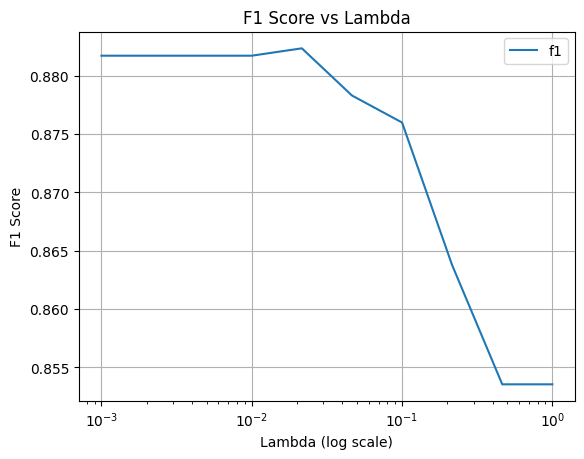

In [50]:
ccd_model.plot(results, measure="f1")

In [51]:
# ccd_model.plot_coefficients(results)

In [52]:
logreg = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.9)
logreg.fit(np.asarray(X_train), y_train)
sklearn_preds = logreg.predict(np.asarray(X_test))
sklearn_f1 = f1_score(y_test, sklearn_preds)

/Users/mikolajmroz/Developer/AML-projects/Project1/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Arrhythmia dataset

In [53]:
df = pd.read_csv('./data/arrhythmia.csv')
X = np.asarray(df.drop(columns='target'))
y = np.asarray(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
all_results = evaluate_logreg_ccd(X_train, y_train, X_test, y_test, "arrhythmia")


Evaluating sklearn LogisticRegression models

Training unregularized logistic regression...
Unregularized LogisticRegression results:
  ROC_AUC: 0.6571
  PR_AUC: 0.6010
  F1: 0.5891
  BALANCED_ACCURACY: 0.6105

Training L1-regularized logistic regression...
L1-regularized LogisticRegression results (best C=0.1):
  ROC_AUC: 0.8734
  PR_AUC: 0.8514
  F1: 0.7321
  BALANCED_ACCURACY: 0.7698

Evaluating with ROC_AUC metric


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]



Best lambda for roc_auc: 0.100000
ROC_AUC: 0.8548
PR_AUC: 0.8531
F1: 0.6863
BALANCED_ACCURACY: 0.7485

Evaluating with PR_AUC metric


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]



Best lambda for pr_auc: 0.464159
ROC_AUC: 0.8463
PR_AUC: 0.8595
F1: 0.3467
BALANCED_ACCURACY: 0.6048

Evaluating with F1 metric


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]



Best lambda for f1: 0.001000
ROC_AUC: 0.8503
PR_AUC: 0.8505
F1: 0.7222
BALANCED_ACCURACY: 0.7672

Evaluating with BALANCED_ACCURACY metric


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]



Best lambda for balanced_accuracy: 0.001000
ROC_AUC: 0.8503
PR_AUC: 0.8505
F1: 0.7222
BALANCED_ACCURACY: 0.7672

All results saved to results/real/arrhythmia/


In [55]:
ccd_model = LogRegCCD(num_lambdas=10)
results, best_lambda = ccd_model.optimize_lambda(X_train, y_train, X_test, y_test, measure="f1")
ccd_model.fit(X_train, y_train, best_lambda)

ccd_probs = ccd_model.predict_proba(X_test)
ccd_preds = (ccd_probs >= 0.5).astype(int)
ccd_f1 = f1_score(y_test, ccd_preds)
print(f"LogRegCCD F1 Score: {ccd_f1:.4f}")

LogRegCCD F1 Score: 0.7222


In [56]:
# Train logistic regression without regularization
logreg_no_reg = LogisticRegression(max_iter=10000, penalty=None)
logreg_no_reg.fit(np.asarray(X_train), y_train)
no_reg_preds = logreg_no_reg.predict(np.asarray(X_test))
no_reg_f1 = f1_score(y_test, no_reg_preds)
print(f"LogisticRegression without regularization F1 Score: {no_reg_f1:.4f}")

# Train logistic regression with L1 regularization
logreg_l1 = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')
logreg_l1.fit(np.asarray(X_train), y_train)
l1_preds = logreg_l1.predict(np.asarray(X_test))
l1_f1 = f1_score(y_test, l1_preds)
print(f"LogisticRegression with L1 penalty F1 Score: {l1_f1:.4f}")

# Count non-zero coefficients to check sparsity
no_reg_nonzero = np.sum(np.abs(logreg_no_reg.coef_) > 1e-5)
l1_nonzero = np.sum(np.abs(logreg_l1.coef_) > 1e-5)
print(f"Number of non-zero coefficients (No regularization): {no_reg_nonzero} out of {logreg_no_reg.coef_.size}")
print(f"Number of non-zero coefficients (L1): {l1_nonzero} out of {logreg_l1.coef_.size}")

# Compare with the upcoming LogRegCCD results
print(f"\nComparison:")
print(f"No regularization LogisticRegression: {no_reg_f1:.4f}")
print(f"L1 LogisticRegression: {l1_f1:.4f}")

LogisticRegression without regularization F1 Score: 0.6165
LogisticRegression with L1 penalty F1 Score: 0.7107
Number of non-zero coefficients (No regularization): 192 out of 214
Number of non-zero coefficients (L1): 107 out of 214

Comparison:
No regularization LogisticRegression: 0.6165
L1 LogisticRegression: 0.7107


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

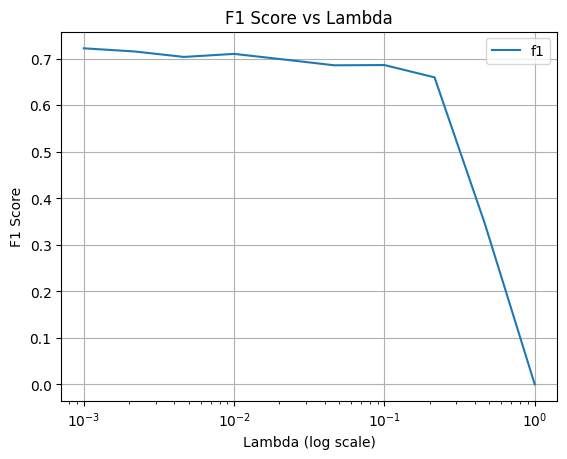

In [57]:
ccd_model.plot(results, measure="f1")

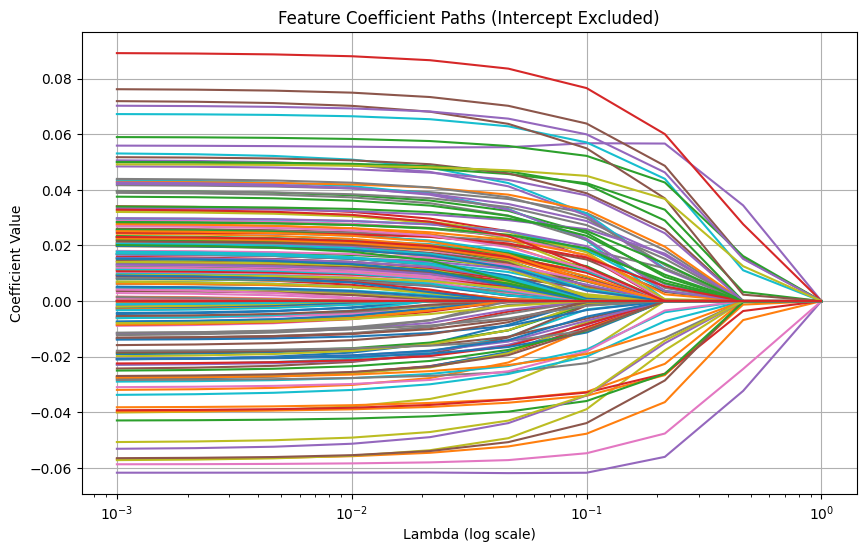

In [58]:
ccd_model.plot_coefficients(results, aggregate=False)

In [59]:
# logreg = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.9)
# logreg.fit(np.asarray(X_train), y_train)
# sklearn_preds = logreg.predict(np.asarray(X_test))
# sklearn_f1 = f1_score(y_test, sklearn_preds)

## Secom dataset

In [5]:
df = pd.read_csv('./data/secom.csv')
X = np.asarray(df.drop(columns='target'))
y = np.asarray(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Evaluating sklearn LogisticRegression models

Training unregularized logistic regression...
Unregularized LogisticRegression results:
  ROC_AUC: 0.6058
  PR_AUC: 0.5942
  F1: 0.6269
  BALANCED_ACCURACY: 0.6043

Training L1-regularized logistic regression...
L1-regularized LogisticRegression results (best C=0.1):
  ROC_AUC: 0.7702
  PR_AUC: 0.8141
  F1: 0.7119
  BALANCED_ACCURACY: 0.7293

Evaluating with ROC_AUC metric


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]



Best lambda for roc_auc: 0.464159
ROC_AUC: 0.7571
PR_AUC: 0.8128
F1: 0.7097
BALANCED_ACCURACY: 0.7142

Evaluating with PR_AUC metric


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



Best lambda for pr_auc: 0.464159
ROC_AUC: 0.7571
PR_AUC: 0.8128
F1: 0.7097
BALANCED_ACCURACY: 0.7142


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

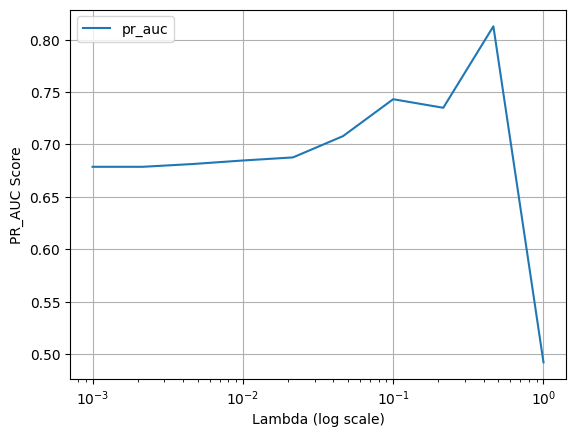

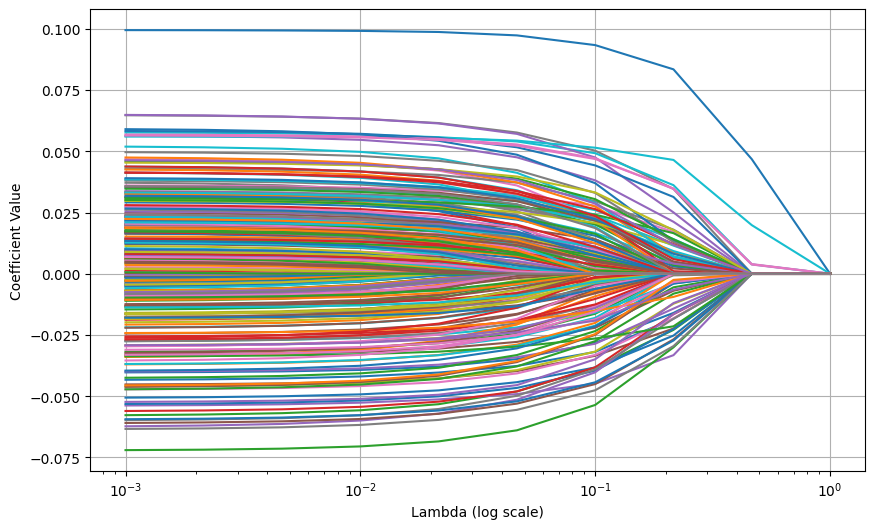

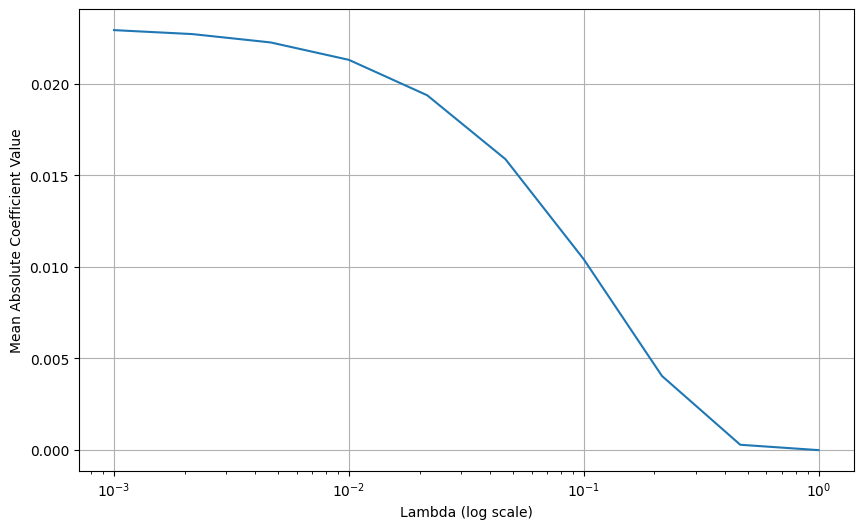


Evaluating with F1 metric


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]



Best lambda for f1: 0.464159
ROC_AUC: 0.7571
PR_AUC: 0.8128
F1: 0.7097
BALANCED_ACCURACY: 0.7142


<Figure size 1000x600 with 0 Axes>

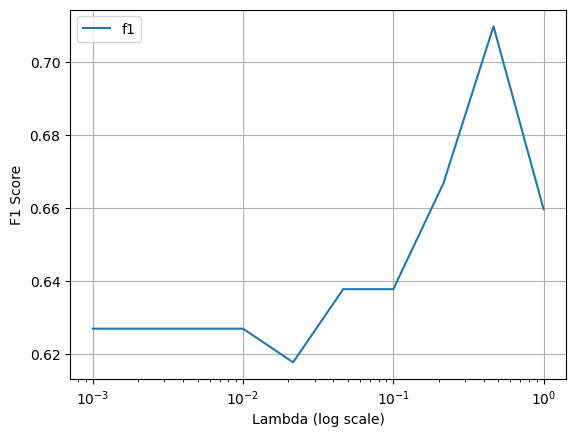

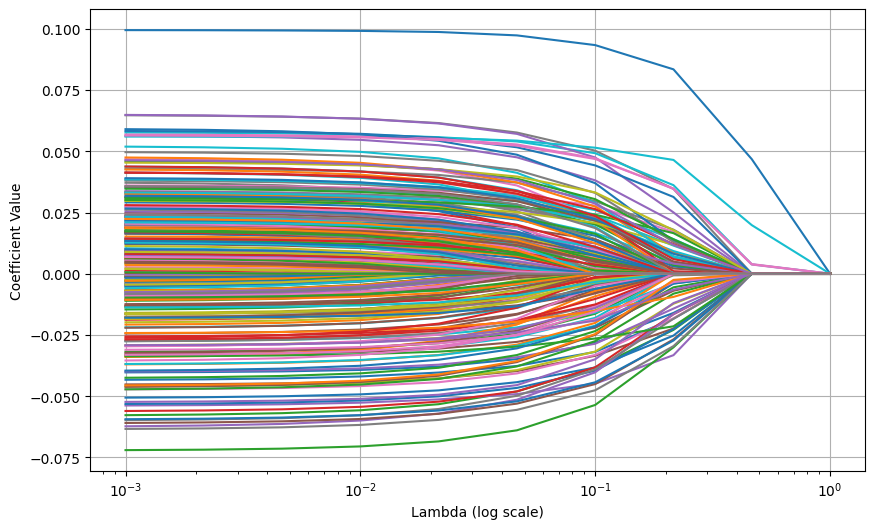

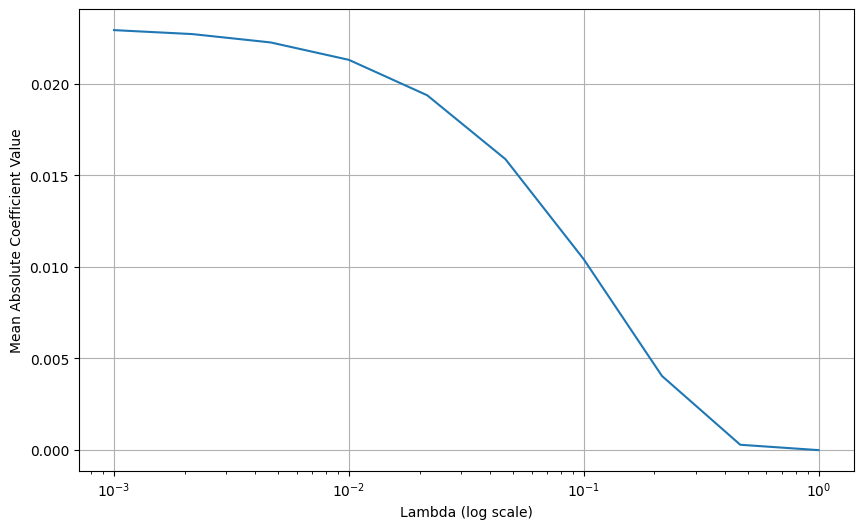


Evaluating with BALANCED_ACCURACY metric


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]



Best lambda for balanced_accuracy: 0.464159
ROC_AUC: 0.7571
PR_AUC: 0.8128
F1: 0.7097
BALANCED_ACCURACY: 0.7142


<Figure size 1000x600 with 0 Axes>

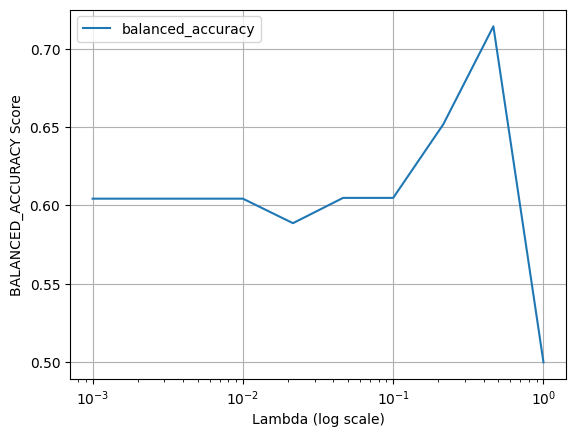

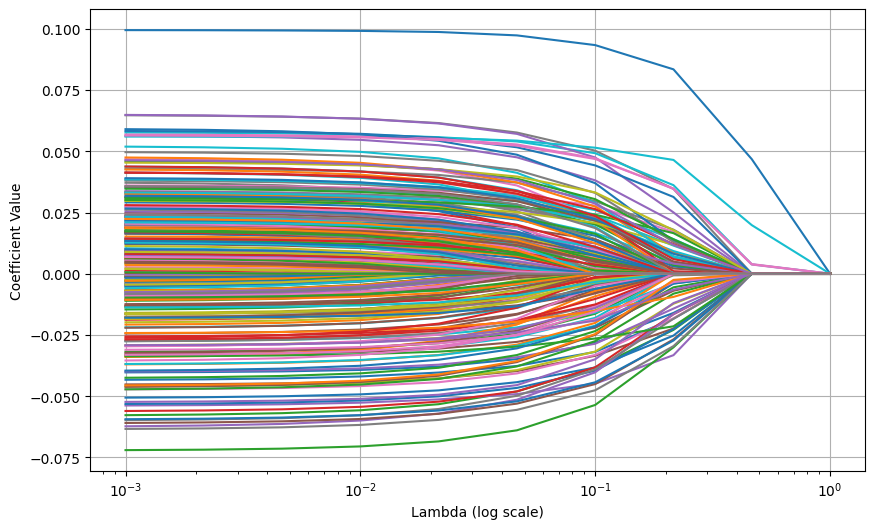

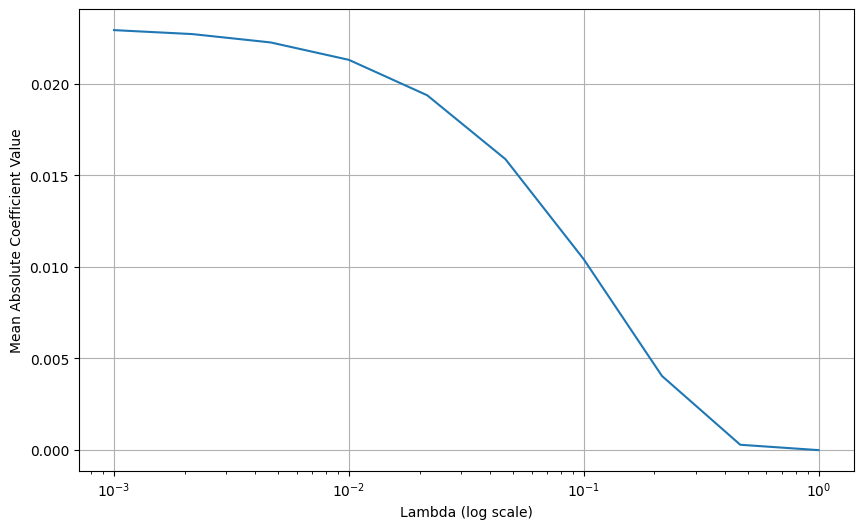


All results saved to results/real/secom/


In [6]:
all_results = evaluate_logreg_ccd(X_train, y_train, X_test, y_test, "secom")

In [7]:
ccd_model = LogRegCCD(num_lambdas=10)
results, best_lambda = ccd_model.optimize_lambda(X_train, y_train, X_test, y_test, measure="f1")
ccd_model.fit(X_train, y_train, best_lambda)

ccd_probs = ccd_model.predict_proba(X_test)
ccd_preds = (ccd_probs >= 0.5).astype(int)
ccd_f1 = f1_score(y_test, ccd_preds)
print(f"LogRegCCD F1 Score: {ccd_f1:.4f}")

LogRegCCD F1 Score: 0.7097


<Figure size 1000x600 with 0 Axes>

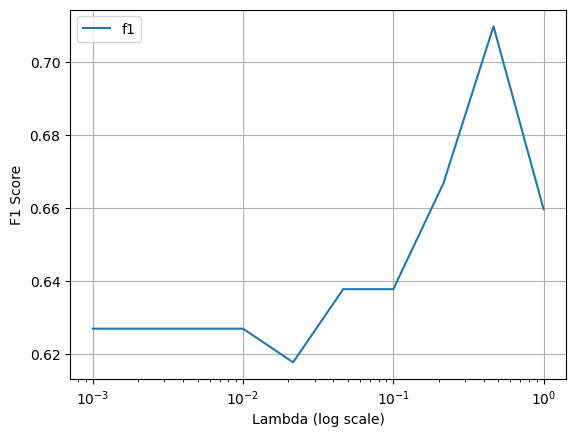

In [8]:
ccd_model.plot(results, measure="f1")

In [64]:
# ccd_model.plot_coefficients(results)

In [65]:
# # Train logistic regression without regularization
# logreg_no_reg = LogisticRegression(max_iter=10000, penalty=None)
# logreg_no_reg.fit(np.asarray(X_train), y_train)
# no_reg_preds = logreg_no_reg.predict(np.asarray(X_test))
# no_reg_f1 = f1_score(y_test, no_reg_preds)
# print(f"LogisticRegression without regularization F1 Score: {no_reg_f1:.4f}")

# # Train logistic regression with L1 regularization
# logreg_l1 = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')
# logreg_l1.fit(np.asarray(X_train), y_train)
# l1_preds = logreg_l1.predict(np.asarray(X_test))
# l1_f1 = f1_score(y_test, l1_preds)
# print(f"LogisticRegression with L1 penalty F1 Score: {l1_f1:.4f}")

# # Count non-zero coefficients to check sparsity
# no_reg_nonzero = np.sum(np.abs(logreg_no_reg.coef_) > 1e-5)
# l1_nonzero = np.sum(np.abs(logreg_l1.coef_) > 1e-5)
# print(f"Number of non-zero coefficients (No regularization): {no_reg_nonzero} out of {logreg_no_reg.coef_.size}")
# print(f"Number of non-zero coefficients (L1): {l1_nonzero} out of {logreg_l1.coef_.size}")

# # Compare with the upcoming LogRegCCD results
# print(f"\nComparison:")
# print(f"No regularization LogisticRegression: {no_reg_f1:.4f}")
# print(f"L1 LogisticRegression: {l1_f1:.4f}")

In [66]:
# logreg = LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', l1_ratio=0.9)
# logreg.fit(np.asarray(X_train), y_train)
# sklearn_preds = logreg.predict(np.asarray(X_test))
# sklearn_f1 = f1_score(y_test, sklearn_preds)

## Ionosphere dataset

In [67]:
df = pd.read_csv('./data/ionosphere.csv')
X = np.asarray(df.drop(columns='target'))
y = np.asarray(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
all_results = evaluate_logreg_ccd(X_train, y_train, X_test, y_test, "ionosphere")


Evaluating sklearn LogisticRegression models

Training unregularized logistic regression...
Unregularized LogisticRegression results:
  ROC_AUC: 0.6818
  PR_AUC: 0.7936
  F1: 0.5333
  BALANCED_ACCURACY: 0.6545

Training L1-regularized logistic regression...
L1-regularized LogisticRegression results (best C=0.1):
  ROC_AUC: 0.6000
  PR_AUC: 0.7154
  F1: 0.5714
  BALANCED_ACCURACY: 0.7000

Evaluating with ROC_AUC metric


100%|██████████| 10/10 [00:00<00:00, 32.13it/s]



Best lambda for roc_auc: 0.464159
ROC_AUC: 0.7000
PR_AUC: 0.7991
F1: 0.6250
BALANCED_ACCURACY: 0.7045

Evaluating with PR_AUC metric


100%|██████████| 10/10 [00:00<00:00, 32.25it/s]



Best lambda for pr_auc: 0.464159
ROC_AUC: 0.7000
PR_AUC: 0.7991
F1: 0.6250
BALANCED_ACCURACY: 0.7045

Evaluating with F1 metric


100%|██████████| 10/10 [00:00<00:00, 31.34it/s]



Best lambda for f1: 0.100000
ROC_AUC: 0.6364
PR_AUC: 0.7474
F1: 0.7059
BALANCED_ACCURACY: 0.7545

Evaluating with BALANCED_ACCURACY metric


100%|██████████| 10/10 [00:00<00:00, 32.21it/s]



Best lambda for balanced_accuracy: 0.100000
ROC_AUC: 0.6364
PR_AUC: 0.7474
F1: 0.7059
BALANCED_ACCURACY: 0.7545

All results saved to results/real/ionosphere/


In [69]:
ccd_model = LogRegCCD(num_lambdas=10)
results, best_lambda = ccd_model.optimize_lambda(X_train, y_train, X_test, y_test, measure="f1")
ccd_model.fit(X_train, y_train, best_lambda)

ccd_probs = ccd_model.predict_proba(X_test)
ccd_preds = (ccd_probs >= 0.5).astype(int)
ccd_f1 = f1_score(y_test, ccd_preds)
print(f"LogRegCCD F1 Score: {ccd_f1:.4f}")

LogRegCCD F1 Score: 0.7059


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

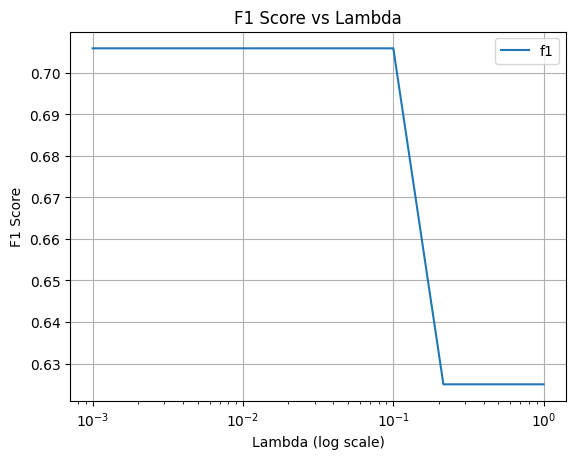

In [70]:
ccd_model.plot(results, measure="f1")

In [71]:
# ccd_model.plot_coefficients(results)

In [72]:
# Train logistic regression without regularization
logreg_no_reg = LogisticRegression(max_iter=10000, penalty=None)
logreg_no_reg.fit(np.asarray(X_train), y_train)
no_reg_preds = logreg_no_reg.predict(np.asarray(X_test))
no_reg_f1 = f1_score(y_test, no_reg_preds)
print(f"LogisticRegression without regularization F1 Score: {no_reg_f1:.4f}")

# Train logistic regression with L1 regularization
logreg_l1 = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')
logreg_l1.fit(np.asarray(X_train), y_train)
l1_preds = logreg_l1.predict(np.asarray(X_test))
l1_f1 = f1_score(y_test, l1_preds)
print(f"LogisticRegression with L1 penalty F1 Score: {l1_f1:.4f}")

# Count non-zero coefficients to check sparsity
no_reg_nonzero = np.sum(np.abs(logreg_no_reg.coef_) > 1e-5)
l1_nonzero = np.sum(np.abs(logreg_l1.coef_) > 1e-5)
print(f"Number of non-zero coefficients (No regularization): {no_reg_nonzero} out of {logreg_no_reg.coef_.size}")
print(f"Number of non-zero coefficients (L1): {l1_nonzero} out of {logreg_l1.coef_.size}")

# Compare with the upcoming LogRegCCD results
print(f"\nComparison:")
print(f"No regularization LogisticRegression: {no_reg_f1:.4f}")
print(f"L1 LogisticRegression: {l1_f1:.4f}")

LogisticRegression without regularization F1 Score: 0.5333
LogisticRegression with L1 penalty F1 Score: 0.5333
Number of non-zero coefficients (No regularization): 30 out of 31
Number of non-zero coefficients (L1): 13 out of 31

Comparison:
No regularization LogisticRegression: 0.5333
L1 LogisticRegression: 0.5333
